In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

### Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier

In [58]:
def create_gauss_filter(h, w, k_size=5, sigma=5):
    #Obtengo el kernel
    nucleo_g = cv.getGaussianKernel(k_size, sigma)
    kernel = nucleo_g * nucleo_g.T

    #Armo una imagen en blanco con el kernel en el centro
    gauss_filter = np.zeros((h,w))

    center_h = h//2
    center_w = w//2
    
    gauss_filter[center_h - k_size // 2:center_h + k_size // 2 + 1, center_w - k_size // 2:center_w + k_size // 2 + 1] = kernel

    img_fft_low = np.fft.fft2(gauss_filter)

    return (gauss_filter, img_fft_low)

In [4]:
def image_quality(image):
    h, w = image.shape
    #Compute F which is the Fourier Transform representation of image I
    F = np.fft.fft2(image)
    #Find Fc which is obtained by shifting the origin of F to centre.
    Fc = np.fft.fftshift(F)
    #Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    Af = np.abs(Fc)
    #Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(Af)
    #Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    Th = np.sum([F > M/1000])
    #Calculate Image Quality measure (FM)
    FM = Th / (h*w)
    return FM

In [5]:
def absolute_central_moment(img):
    hist,_ = np.histogram(img.ravel(),256,[0,256])
    #Calculo la intensidad media    
    u = np.mean(img)
    # Calcular la frecuencia relativa
    frec_rel = hist / float(np.sum(hist))
    ACM = 0
    for k in range(256):
        ACM += np.abs(k-u)*frec_rel[k]
    return ACM

In [51]:
def apply_gauss_filter(img, kernel_size, sigma):
    h, w = img.shape
    _, kernel_tf = create_gauss_filter(h, w, k_size=kernel_size, sigma=sigma)
    img_fft = np.fft.fft2(img)
    filtered = img_fft * kernel_tf
    return np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

### 1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral. 

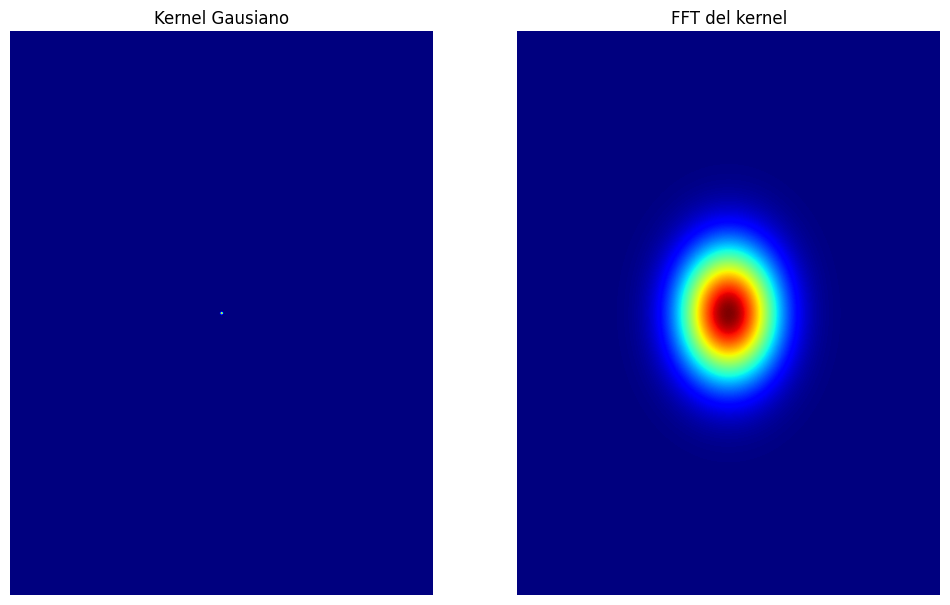

In [61]:
img= cv.imread('./imgs/mariposa.jpg', cv.IMREAD_GRAYSCALE)
h, w = img.shape
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

(1600, 1200)

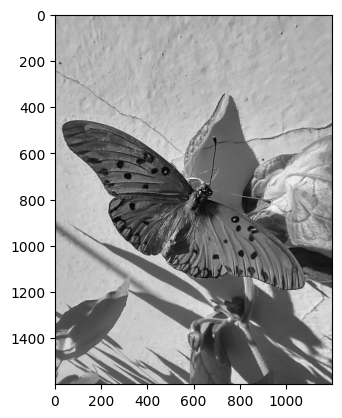

In [60]:
plt.imshow(img, cmap='gray')
img.shape

### 2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
### 3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

In [56]:
kernel_size = 15
sigma1 = 2
sigma2 = 7
sigma3 = 15

img_fourier_1 = apply_gauss_filter(img, kernel_size, sigma1)
img_fourier_2 = apply_gauss_filter(img, kernel_size, sigma2)
img_fourier_3 = apply_gauss_filter(img, kernel_size, sigma3)

img_GB_1 = cv.GaussianBlur(img, ksize=(kernel_size, kernel_size), sigmaX=sigma1, sigmaY=sigma1)
img_GB_2 = cv.GaussianBlur(img, ksize=(kernel_size, kernel_size), sigmaX=sigma2, sigmaY=sigma2)
img_GB_3 = cv.GaussianBlur(img, ksize=(kernel_size, kernel_size), sigmaX=sigma3, sigmaY=sigma2)

iq_1 = image_quality(img_fourier_1)
acm_1 = absolute_central_moment(img_fourier_1)
iq_2 = image_quality(img_fourier_2)
acm_2 = absolute_central_moment(img_fourier_2)
iq_3 = image_quality(img_fourier_3)
acm_3 = absolute_central_moment(img_fourier_3)

iq_4 = image_quality(img_GB_1)
acm_4 = absolute_central_moment(img_GB_1)
iq_5 = image_quality(img_GB_2)
acm_5 = absolute_central_moment(img_GB_2)
iq_6 = image_quality(img_GB_3)
acm_6 = absolute_central_moment(img_GB_3)


C:\Users\azuly\AppData\Local\Temp\ipykernel_6972\61863301.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


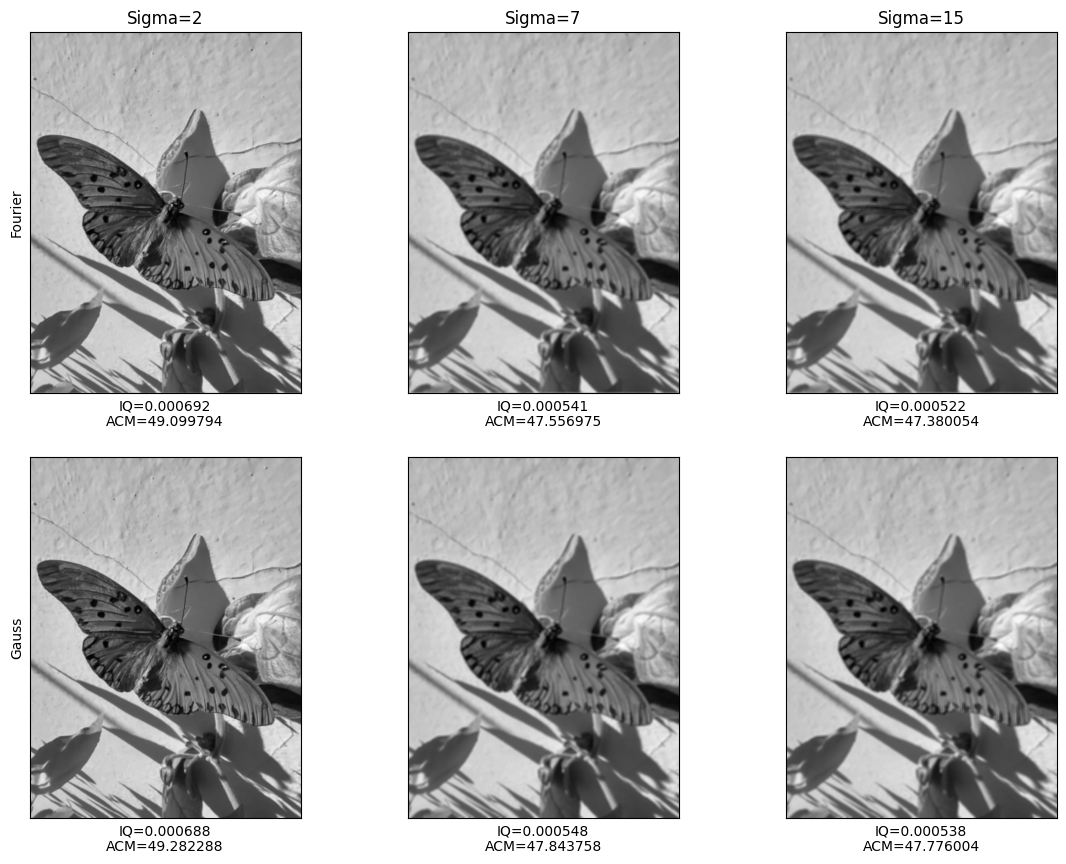

In [57]:
fig = plt.figure(figsize=(12, 9))

ax1=plt.subplot(231)
ax1.set_title('Sigma=' + str(sigma1))
ax1.imshow(img_fourier_1, cmap='gray')
ax2=plt.subplot(232)
ax2.set_title('Sigma=' + str(sigma2))
ax2.imshow(img_fourier_2, cmap='gray')
ax3=plt.subplot(233)
ax3.set_title('Sigma=' + str(sigma3))
ax3.imshow(img_fourier_3, cmap='gray')
ax4=plt.subplot(234)
ax4.imshow(img_GB_1, cmap='gray')
ax5=plt.subplot(235)
ax5.imshow(img_GB_2, cmap='gray')
ax6=plt.subplot(236)
ax6.imshow(img_GB_3, cmap='gray')

ax1.xaxis.set_tick_params(labelbottom=False)
ax1.yaxis.set_tick_params(labelleft=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Fourier')
ax1.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_1, acm_1))

ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_2, acm_2))

ax3.xaxis.set_tick_params(labelbottom=False)
ax3.yaxis.set_tick_params(labelleft=False)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_3, acm_3))

ax4.xaxis.set_tick_params(labelbottom=False)
ax4.yaxis.set_tick_params(labelleft=False)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_ylabel('Gauss')
ax4.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_4,acm_4))

ax5.xaxis.set_tick_params(labelbottom=False)
ax5.yaxis.set_tick_params(labelleft=False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_5, acm_5))

ax6.xaxis.set_tick_params(labelbottom=False)
ax6.yaxis.set_tick_params(labelleft=False)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_xlabel('IQ={0:.6f}\nACM={1:.6f}'.format(iq_6, acm_6))

fig.tight_layout(pad=2)
fig.show()